# import statements and load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split

In [2]:
image_dir = 'adversarial'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device.')

torch.manual_seed(42)
np.random.seed(42)

Using cuda device.


In [3]:
labels = pd.read_csv('adversarial_features.csv')
# labels = labels[['patient','dm_time', 'age', 'educational_level', 'sex']]
# labels = labels.set_index('patient')
labels.head()

,patient,dm_time,age,educational_level,sex
0,10000,15.0,63.0,4.0,0.0
1,10001,15.0,63.0,4.0,0.0
2,10002,15.0,63.0,4.0,0.0
3,10003,15.0,63.0,4.0,0.0
4,10004,13.0,64.0,2.0,0.0


In [4]:
# scale the tabular quantitative features only
scaler = StandardScaler()
scaled = scaler.fit_transform(labels[['dm_time', 'age']])
labels[['dm_time', 'age']] = scaled

In [5]:
# Preprocess the data to be the same as the ImageNet ones
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize directly because images are square
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# Load the dataset using ImageFolder
image_dataset = datasets.ImageFolder(root=image_dir, transform=transform)

In [6]:
labels.set_index('patient', inplace=True)

In [7]:
labels.head()

,dm_time,age,educational_level,sex
patient,,,,
10000,0.133419,0.167065,4.0,0.0
10001,0.133419,0.167065,4.0,0.0
10002,0.133419,0.167065,4.0,0.0
10003,0.133419,0.167065,4.0,0.0
10004,-0.073432,0.261988,2.0,0.0


# create architecture and test function

In [8]:
class MultimodalDataset(Dataset):
    def __init__(self, image_dir, tabular_data, transform=None):
        """
        Args:
            image_dir (str): Directory containing images.
            tabular_data (pd.DataFrame): Dataframe containing labels.
            transform (callable, optional): Optional transform for the image data.
        """
        self.image_dataset = datasets.ImageFolder(root=image_dir, transform=transform)
        self.tabular_data = tabular_data
        self.image_filenames = [x[0].split('/')[-1] for x in self.image_dataset.imgs]
        self.transform = transform

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, idx):
        # Load image from ImageFolder
        img, label = self.image_dataset[idx]
        
        image_filename = self.image_filenames[idx]

        patient_id = int(image_filename.split('.')[0])

        # Match the image filename to the corresponding row in the tabular data
        tabular = torch.tensor(self.tabular_data.loc[patient_id, :].to_numpy(), dtype=torch.float32)
        
        return img, tabular, label, image_filename

In [9]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__() # inherit from nn.Module
        self.attn = nn.MultiheadAttention(embed_dim = dim, num_heads = num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(dim)
        self.feedforward = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim),
        )
        self.norm_feedforward = nn.LayerNorm(dim)

    def forward(self, q, kv):
        # architecture is standard transformer encoder block: attn -> add+norm -> mlp -> add+norm
        attn_output, attn_output_weights = self.attn(q, kv, kv) # in cross attention, let one modality (q) attend to another (kv)
        x = self.norm(q + attn_output) # residual connection
        ff_output = self.feedforward(x) # mlp
        return self.norm_feedforward(x + ff_output) # residual connection

class BidirectionalCrossAttention(nn.Module):
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.img_to_tab = CrossAttentionBlock(dim, num_heads, dropout)
        self.tab_to_img = CrossAttentionBlock(dim, num_heads, dropout)
        # return img_out, tab_out

    def forward(self, img_embed, tab_embed):
        img_out = self.img_to_tab(img_embed, tab_embed)
        tab_out = self.tab_to_img(tab_embed, img_embed)
        return img_out, tab_out
        
class MultimodalClassifier(nn.Module):
    def __init__(self, fusion_method='cross_attend', embed_dim=512, num_heads=4):
        super().__init__() # inherit

        # image encoder -- acquire the img embeddings from finetuned resnet
        resnet = models.resnet18(weights='DEFAULT')
        resnet.fc = nn.Linear(resnet.fc.in_features, 5)
        resnet.load_state_dict(torch.load("resnet_finetuned.pth"))
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.image_encoder.eval()
        for param in self.image_encoder.parameters(): # fix the resnet weights
            param.requires_grad = False

        # cross attention
        self.cross_attn = BidirectionalCrossAttention(dim=embed_dim, num_heads=num_heads)

        # classifier head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim, 5) # 5 total classes to predict upon
        )

        # linear layer for combining multimodal data
        self.fc_combine = nn.Linear(embed_dim * 2, embed_dim * 2)

        self.scalar_projector = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.LayerNorm(embed_dim)
        )
        self.fusion_method = fusion_method

    def forward(self, images, tabular):
        fused = self.get_embeddings(images, tabular, kind=self.fusion_method)
        logits = self.classifier(fused) # [B, num_classes]
        return logits, fused
        
    def get_embeddings(self, images, tabular, kind=None):
        if kind is None:
            kind = self.fusion_method
        # image encoding
        self.image_encoder.eval()
        B = images.size(0)
        x = self.image_encoder(images) # shape: [B, 512, 7, 7]
        # print("NaNs in image encoder output:", torch.isnan(x).any(), x.mean(), x.std())
        img_embed = x.flatten(2).permute(0, 2, 1) # [B, 49, 512]
        
        # tabular encoding
        tab_embed = []
        for i in range(tabular.shape[1]):
            feat = tabular[:, i].unsqueeze(-1)  # [B, 1]
            emb = self.scalar_projector(feat)   # [B, D]
            tab_embed.append(emb)
        tab_embed = torch.stack(tab_embed, dim=1)  # [B, num_features, D]

        # attempting different methods of combining the encodings
        ## bidirectional cross attention
        if kind == 'cross_attend':
            print(f'Performing cross attention fusion.')
            img_updated, tab_updated = self.cross_attn(img_embed, tab_embed)
            img_pooled = img_updated.mean(dim=1) # [B, D]
            tab_pooled = tab_updated.mean(dim=1) # [B, D]
    
            fused = torch.cat([img_pooled, tab_pooled], dim=1) # [B, 2D]

        # ## concatenation
        if kind == 'concatenate':
            print(f'Performing concatenation fusion.')
            img_pooled = img_embed.mean(dim=1)  # [B, 512]
            tab_pooled = tab_embed.mean(dim=1)  # [B, 512]
            
            fused = torch.cat([img_pooled, tab_pooled], dim=1)  # [B, 1024]
        
        # ## fully connected layer
        if kind == 'fc_layer':
            print(f'Performing fully connected layer fusion.')
            img_pooled = img_embed.mean(dim=1)  # [B, 512]
            tab_pooled = tab_embed.mean(dim=1)  # [B, 512]
            
            fused = torch.cat([img_pooled, tab_pooled], dim=1)  # [B, 1024]
            fused = self.fc_combine(fused)
 
        return fused

In [10]:
# test loop
def test_model(model, dataloader, loss_fn, device, save_prefix=None):
    model.to(device)
    model.eval()

    logits_list, labels_list, embeddings, filenames = [], [], [], []
    
    with torch.no_grad():
        for images, tabulars, labels_batch, batch_filenames in dataloader:
            # unload data and send to device
            images, tabulars, labels_batch = images.to(device), tabulars.to(device), labels_batch.to(device)

            # forward pass
            outputs, fused = model(images, tabulars)

            # calculate loss
            loss = loss_fn(outputs, labels_batch)

            logits_list.append(outputs.cpu())
            labels_list.append(labels_batch.cpu())
            embeddings.append(fused.detach().cpu())
            filenames.extend(batch_filenames)

    # Convert to NumPy
    logits = torch.cat(logits_list).detach().numpy()
    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    preds = probs.argmax(axis=1)
    true = torch.cat(labels_list).cpu().numpy()

    # Compute metrics
    acc = accuracy_score(true, preds)
    try:
        auroc = roc_auc_score(true, probs, multi_class='ovr')  # or 'ovo'
    except ValueError:
        auroc = float('nan')  # If a class is missing in val_true
    
    print(f"Accuracy: {acc:.4f} | AUROC: {auroc:.4f}")

    # Stack all batches of embeddings into a single array
    embeddings = torch.cat(embeddings, dim=0).detach().numpy()
    
    if save_prefix is not None:
        prefix = save_prefix
        np.save(f"{prefix}/test_fused_embeddings.npy", embeddings)
        np.save(f"{prefix}/test_labels.npy", true)
        np.save(f"{prefix}/test_preds.npy", preds)
        np.save(f"{prefix}/test_logits.npy", logits)
        pd.DataFrame({"filename": filenames}).to_csv(f"{prefix}/test_filenames.csv", index=False)
                
    return {
            "acc": acc,
            "auroc": auroc,
            "preds": preds,
            "true": true
            }

# run the model

In [29]:
version = 'P' # used A, B, C, D, E, F, G
prefix = f'may10_{version}'
path = prefix
import os
os.makedirs(path)

In [12]:
full_dataset = MultimodalDataset(image_dir=image_dir, tabular_data=labels, transform=transform)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

In [31]:
# Load the cross-attn model
best_model = MultimodalClassifier(fusion_method='fc_layer').to(device)
best_model.load_state_dict(torch.load(f"may10_L/best_model.pth"))

optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

adversarial_results = test_model(
    model=best_model,
    dataloader=full_loader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    device=device,
    save_prefix=prefix
)

Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Accuracy: 0.2600 | AUROC: 0.5490


In [32]:
with open(f"{prefix}/all_adversarial_results.pkl", "wb") as f:
    pickle.dump(adversarial_results, f)

# view results

In [33]:
adversarial_results

{'acc': 0.26,
 'auroc': 0.5489999999999999,
 'preds': array([0, 0, 0, 0, 4, 0, 3, 0, 0, 4, 4, 0, 0, 0, 0, 0, 3, 3, 0, 4, 0, 4,
        0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 4, 4, 3, 0, 0, 4, 4, 0, 3, 0, 3, 3,
        0, 4, 3, 0, 0, 0, 3, 3, 3, 0, 3, 4, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0,
        3, 4, 3, 3, 0, 2, 3, 4, 0, 4, 4, 0, 4, 0, 0, 4, 3, 4, 0, 4, 4, 4,
        4, 4, 0, 0, 3, 0, 3, 4, 3, 3, 0, 0]),
 'true': array([3, 1, 0, 1, 1, 0, 4, 0, 2, 4, 4, 1, 0, 1, 0, 0, 2, 4, 2, 3, 3, 4,
        0, 4, 3, 1, 3, 4, 1, 2, 3, 4, 0, 4, 1, 0, 1, 2, 1, 2, 4, 2, 1, 2,
        3, 3, 4, 0, 2, 1, 4, 3, 3, 3, 4, 3, 1, 0, 2, 0, 3, 0, 4, 0, 2, 2,
        2, 1, 4, 2, 1, 3, 4, 3, 2, 4, 1, 0, 3, 2, 1, 0, 4, 3, 0, 0, 1, 3,
        0, 3, 0, 2, 4, 2, 4, 3, 2, 2, 1, 1])}

In [36]:
def plot_cf(results, title, fold_idx=0):
    """
    Creates a confusion matrix in line with our default style.
    results: dictionary
    fold_idx: int

    Returns: matplotlib.figure.Figure object.
    """
    preds = results["preds"]
    true = results["true"]
    
    cm = confusion_matrix(true, preds)
    
    unique_labels = np.unique(np.concatenate([true, preds]))
    class_labels = [f"class_{i}" for i in unique_labels]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=True)
    
    # Set plot spines to white
    for spine in ax.spines.values():
        spine.set_color("white")
    
    # Set colorbar border to white
    cbar = disp.im_.colorbar
    if cbar:
        cbar.outline.set_edgecolor("white")
    plt.tight_layout()
    plt.title(title)
    plt.show()
    return fig

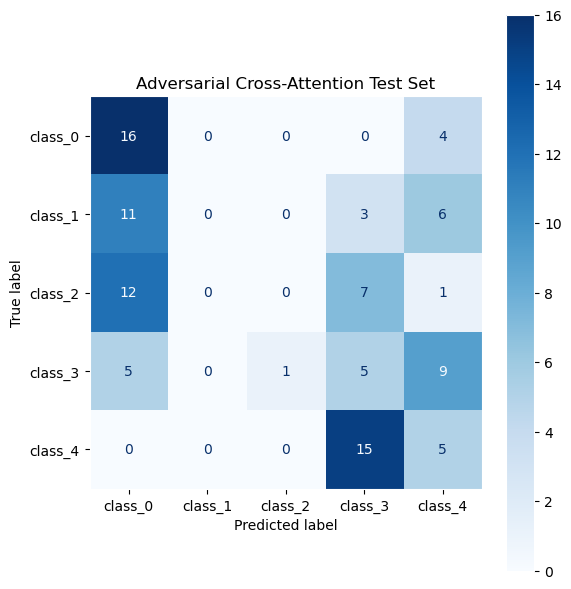

In [37]:
foo = plot_cf(adversarial_results, 'Adversarial Cross-Attention Test Set')
foo.savefig(f"{prefix}/test_cf.png", dpi=300, bbox_inches='tight')

In [1]:
from common_functions import plot_cf


In [2]:
import pickle
filepath = 'may10_P/all_adversarial_results.pkl'
with open(filepath, 'rb') as f:
    data = pickle.load(f)

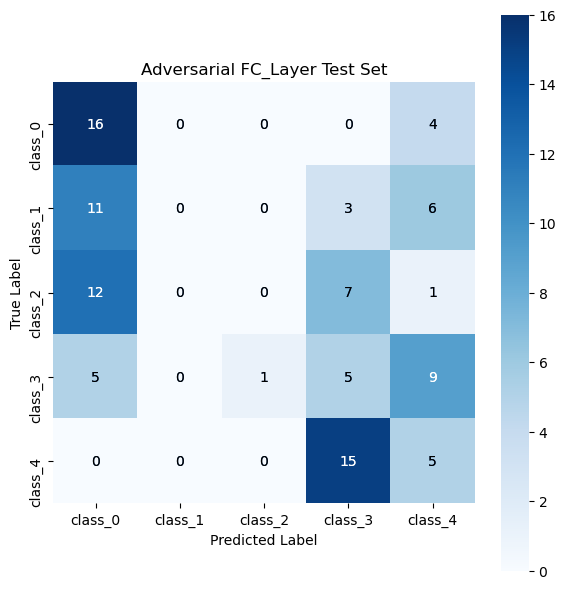

In [4]:
foo = plot_cf(data['preds'], data['true'], 'Adversarial FC_Layer Test Set')

In [6]:
prefix = 'may10_P'
foo.savefig(f"{prefix}/test_cf.png", dpi=300, bbox_inches='tight')